In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
from moviepy.editor import VideoFileClip
import glob
%matplotlib inline

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def warp_transform(image, reverse=False):
    img_size = (image.shape[1], image.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    if reverse:
        return cv2.warpPerspective(image, M_inv, img_size, flags=cv2.INTER_LINEAR)
    else:
        return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output


def hls_select(image, thresh=(0, 255)):
    # detect lane lines by saturation
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def combined_threshold(image, sobel_kernel=3):
    # apply multiple threshold functions
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, thresh=(50, 200))
    dir_binary = dir_threshold(
        image, sobel_kernel=sobel_kernel, thresh=(0.7, 1.3))
    s_binary = hls_select(image, thresh=(170, 255))
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((mag_binary == 1) & (dir_binary == 1))
                    | (s_binary == 1)] = 1
    return combined_binary

In [2]:
class Lane():

    def __init__(self):
        self.best_fit = None
        self.current_fit = None


class Lanes():

    def __init__(self):
        self.detected = False
        self.ploty = None
        self.mtx = None
        self.dist = None
        self.left_lane = Lane()
        self.right_lane = Lane()

    def curvature(self):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(
            self.ploty * ym_per_pix, self.left_lane.best_fit * xm_per_pix, 2)
        right_fit_cr = np.polyfit(
            self.ploty * ym_per_pix, self.right_lane.best_fit * xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * np.max(
            self.ploty) * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * np.max(
            self.ploty) * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])

        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad)

    def detect_lanes(self, binary_warped):
        if self.detected:
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 50
            left_lane_inds = ((nonzerox > (self.left_lane.current_fit[0] * (nonzeroy**2) + self.left_lane.current_fit[1] * nonzeroy + self.left_lane.current_fit[2] - margin)) &
                              (nonzerox < (self.left_lane.current_fit[0] * (nonzeroy**2) + self.left_lane.current_fit[1] * nonzeroy + self.left_lane.current_fit[2] + margin)))
            right_lane_inds = ((nonzerox > (self.right_lane.current_fit[0] * (nonzeroy**2) + self.right_lane.current_fit[1] * nonzeroy + self.right_lane.current_fit[2] - margin)) &
                               (nonzerox < (self.right_lane.current_fit[0] * (nonzeroy**2) + self.right_lane.current_fit[1] * nonzeroy + self.right_lane.current_fit[2] + margin)))


            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            self.left_lane.current_fit = np.polyfit(lefty, leftx, 2)
            self.right_lane.current_fit = np.polyfit(righty, rightx, 2)
            self.ploty = np.linspace(0, binary_warped.shape[
                                     0] - 1, binary_warped.shape[0])
            self.left_lane.best_fit = self.left_lane.current_fit[
                0] * self.ploty**2 + self.left_lane.current_fit[1] * self.ploty + self.left_lane.current_fit[2]
            self.right_lane.best_fit = self.right_lane.current_fit[
                0] * self.ploty**2 + self.right_lane.current_fit[1] * self.ploty + self.right_lane.current_fit[2]

        else:
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(
                binary_warped[binary_warped.shape[0] / 2:, :], axis=0)
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack(
                (binary_warped, binary_warped, binary_warped)) * 255
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0] / 2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0] / nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
        
            leftx_current = leftx_base
            rightx_current = rightx_base

            margin = 100

            minpix = 50

            left_lane_inds = []
            right_lane_inds = []


            for window in range(nwindows):

                win_y_low = binary_warped.shape[
                    0] - (window + 1) * window_height
                win_y_high = binary_warped.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                              (win_xleft_high, win_y_high), (0, 255, 0), 2)
                cv2.rectangle(out_img, (win_xright_low, win_y_low),
                              (win_xright_high, win_y_high), (0, 255, 0), 2)
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
                    nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
                    nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their
                # mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            # Fit a second order polynomial to each
            self.left_lane.current_fit = np.polyfit(lefty, leftx, 2)

            # Generate x and y values for plotting
            self.right_lane.current_fit = np.polyfit(righty, rightx, 2)
            self.ploty = np.linspace(0, binary_warped.shape[
                                     0] - 1, binary_warped.shape[0])
            self.left_lane.best_fit = self.left_lane.current_fit[
                0] * self.ploty**2 + self.left_lane.current_fit[1] * self.ploty + self.left_lane.current_fit[2]
            self.right_lane.best_fit = self.right_lane.current_fit[
                0] * self.ploty**2 + self.right_lane.current_fit[1] * self.ploty + self.right_lane.current_fit[2]
            self.detected = True

        return


In [3]:


def draw_lane_line(warped, undist, lanes):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    pts_left = np.array(
        [np.transpose(np.vstack([lanes.left_lane.best_fit, lanes.ploty]))])
    pts_right = np.array(
        [np.flipud(np.transpose(np.vstack([lanes.right_lane.best_fit, lanes.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective
    # matrix (Minv)
    newwarp = warp_transform(color_warp, reverse=True)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Calculate curvatures and offset from center of the lane
    curvatures = lanes.curvature()
    curvatures_text = "left line radius: {:8.2f}m, right line radius: {:8.2f}m".format(
        float(curvatures[0]), float(curvatures[1]))
    cv2.putText(result, curvatures_text, (10, 20),
                cv2.FONT_HERSHEY_PLAIN, 1.3, (255, 255, 255))
    offset_from_center = (result.shape[
                          1] / 2 - (lanes.left_lane.best_fit[-1] + lanes.right_lane.best_fit[-1]) / 2) * 3.7 / 700
    offset_from_center_text = "offset from center of the line: {:2.5f}m".format(
        offset_from_center)
    cv2.putText(result, offset_from_center_text, (10, 40),
                cv2.FONT_HERSHEY_PLAIN, 1.3, (255, 255, 255))
    return result

In [4]:
def calculate_camera_matrix_dist_coeffs():
    nx = 9
    ny = 6    
    
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    fnames = glob.glob("camera_cal/calibration*.jpg")

    for fname in fnames:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    # use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
    ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2],None,None)
    return (cameraMatrix, distortionCoeffs)

mtx, dist = calculate_camera_matrix_dist_coeffs()

In [5]:
def show_original_processed_img(img, processed,pre_title='Original Image', post_title='Processed Image'):
    # Plot the original and undistorted images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(pre_title, fontsize=25)
    ax2.imshow(processed)
    ax2.set_title(post_title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def pipeline(image, lanes, show_images = False):    
    undistorted = undistort(image, lanes.mtx, lanes.dist)
    
    if show_images:
        show_original_processed_img(image, undistorted, "Original", "Undistorted")
    
    # find lane line by threshold function
    
    thresholded = combined_threshold(undistorted)
    
    if show_images:
        show_original_processed_img(undistorted, thresholded, "Undistorted", "Thresholded")  
    
    warped = warp_transform(thresholded)
    
    if show_images:
        show_original_processed_img(thresholded, warped, "Thresholded", "Warped")

    lanes.detect_lanes(warped)
    processed = draw_lane_line(warped, undistorted, lanes)

    return processed

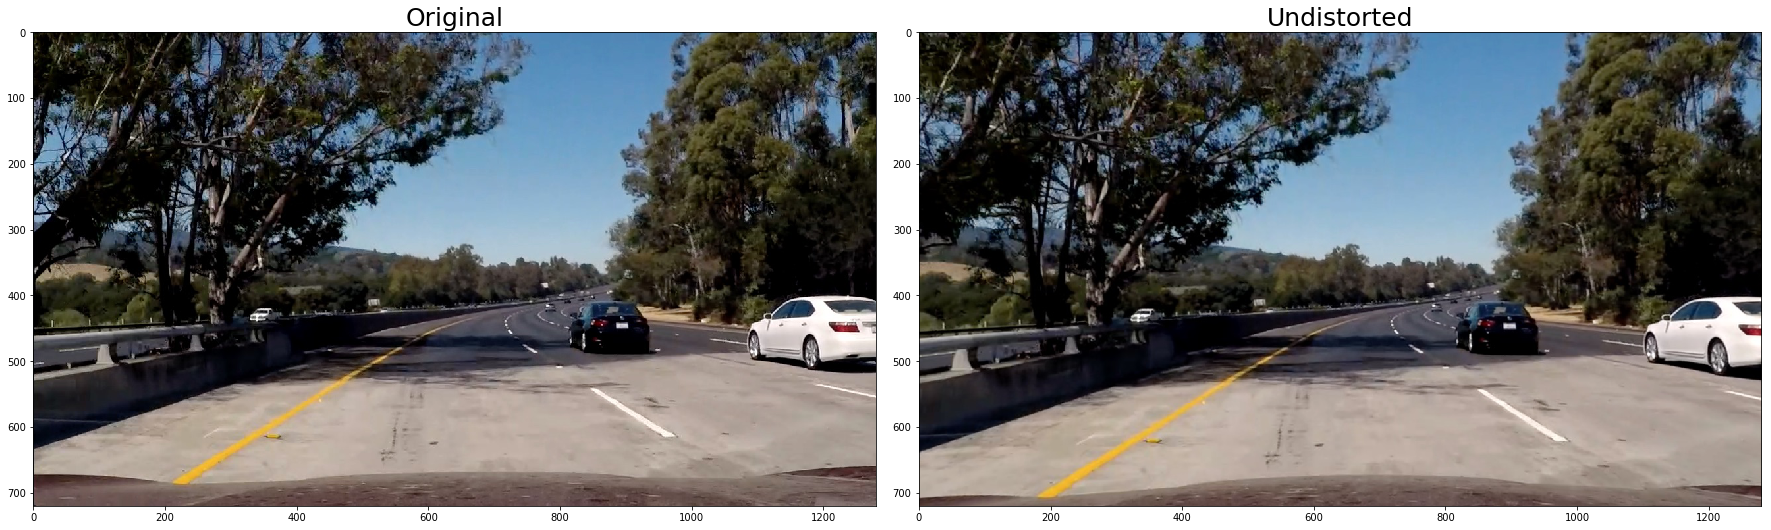

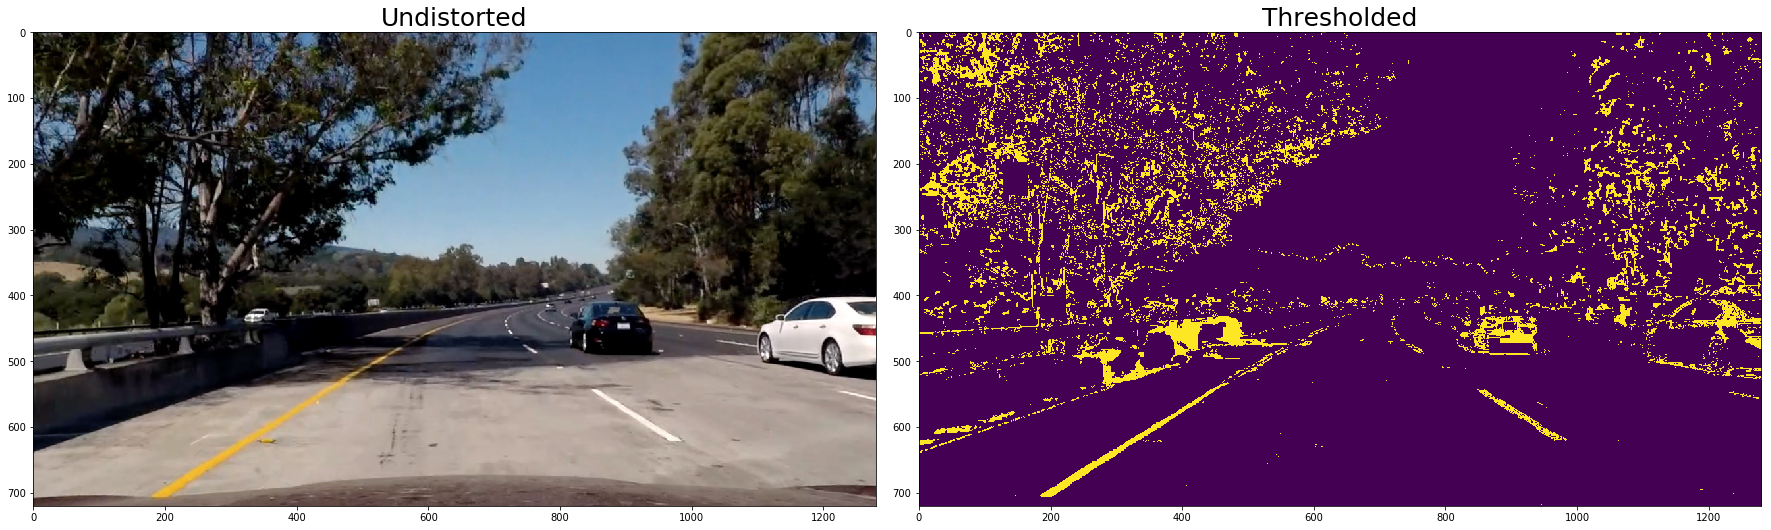

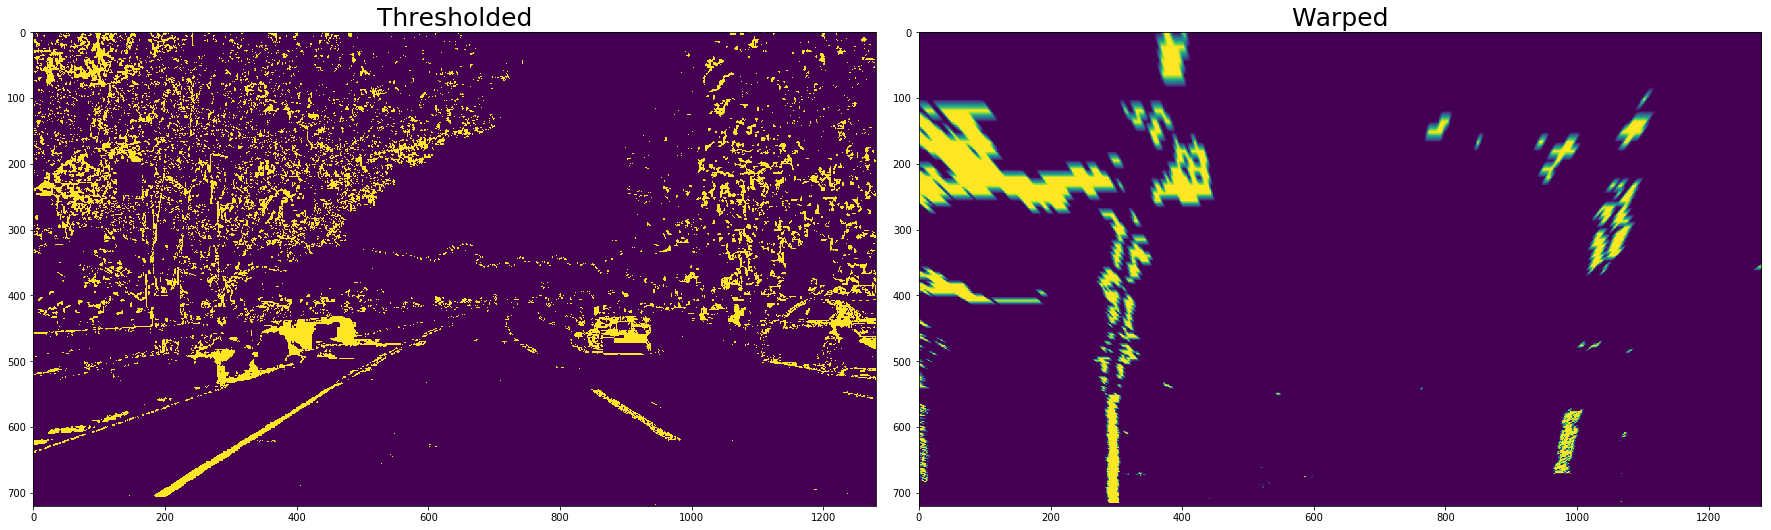

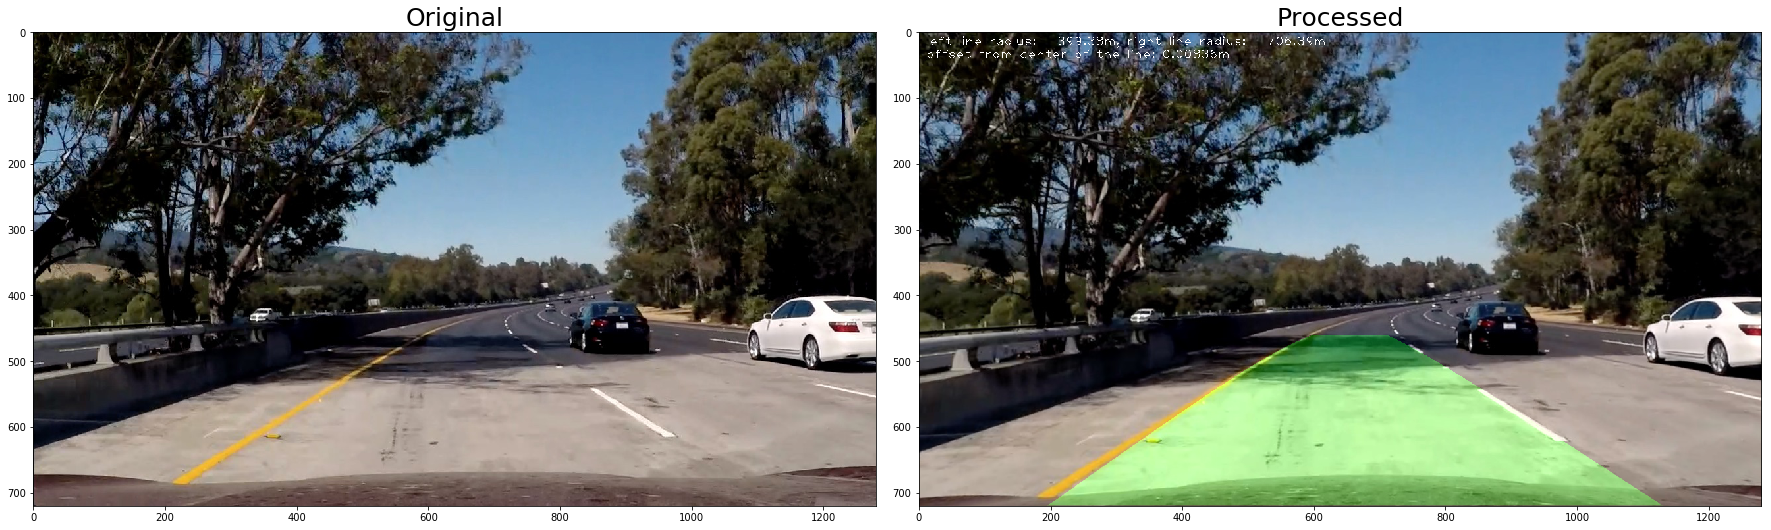

In [7]:

def process_test_images():
    
    fnames = glob.glob('test_images/test5.jpg')
    
    for fname in fnames:
        img = mpimg.imread(fname)
    
        # Process the image using our pipeline
        lane = Lanes()
        lane.mtx, lane.dist = (mtx,dist)
        processed_image = pipeline(img, lane, True)
        show_original_processed_img(img, processed_image, "Original", "Processed")
    plt.show()    
    

process_test_images()

In [8]:
def process_video(single_frame=False):
    destination = 'processed_simple.mp4'
    source = VideoFileClip("project_video.mp4")
    lane = Lanes()
    lane.mtx, lane.dist = (mtx,dist)
    video = source.fl_image(lambda frame: pipeline(frame, lane))
    video.write_videofile(destination, audio=False)

process_video()   
print("Processing Done ...")

[MoviePy] >>>> Building video processed_simple.mp4
[MoviePy] Writing video processed_simple.mp4


100%|█████████▉| 1260/1261 [07:02<00:00,  3.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_simple.mp4 

Processing Done ...
